<a href="https://colab.research.google.com/github/Andres8bit/Machine-Learning/blob/main/Graph_Neural_Network_Classification_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import pandas as pd
import numpy as np
import networkx as nx # Python library for complex graph structures
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
# Load in dataset Cora: 
#                       Consists of 2708 scientific publications 
#                       classified into one of seven classes. 
 
zip_file = keras.utils.get_file(
    fname = "cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)

data_dir = os.path.join(os.path.dirname(zip_file), "cora")

172032/168052 [==============================] - 0s 2us/step


In [7]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)


Citations shape: (5429, 2)


In [8]:
# Sample of dataframe:
#                     target === paperID cited by paper in source
citations.sample(frac=1).head()

,target,source
3417,61069,1153816
2514,27241,1106492
3436,62417,41216
5346,696345,2658
1099,5075,5064


In [9]:
# Load papers into DataFrame:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)


Papers shape: (2708, 1435)


In [10]:
print(papers.sample(5).T)

                            1992  ...                728 
paper_id                 1131335  ...               97390
term_0                         1  ...                   0
term_1                         0  ...                   0
term_2                         0  ...                   0
term_3                         0  ...                   0
...                          ...  ...                 ...
term_1429                      0  ...                   0
term_1430                      0  ...                   0
term_1431                      0  ...                   0
term_1432                      0  ...                   0
subject    Probabilistic_Methods  ...  Genetic_Algorithms

[1435 rows x 5 columns]


In [11]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [12]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])


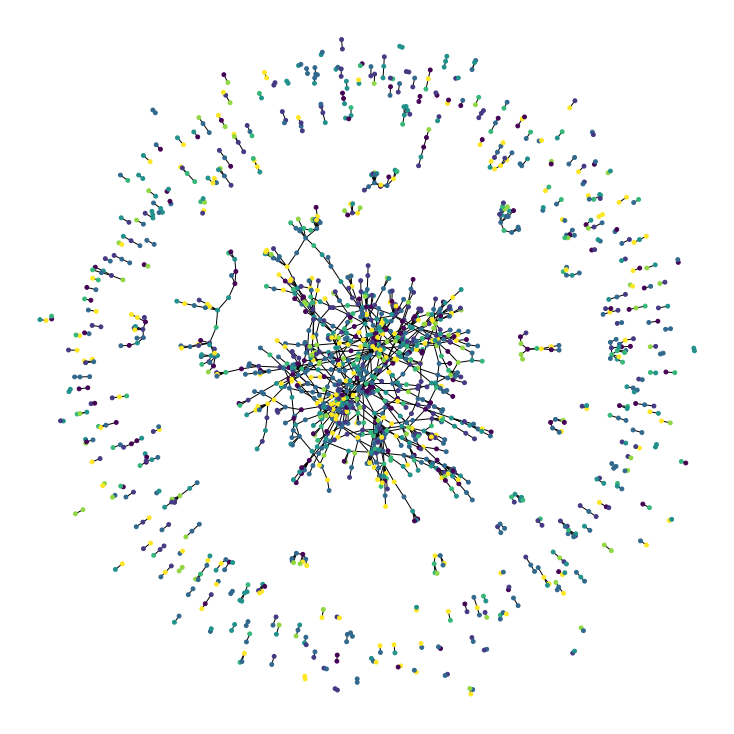

In [13]:
# visualization of Citation Graph:
plt.figure(figsize=(10,10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15,node_color=subjects)

In [14]:
# Split Dataset into Train and Test sets:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)



Train data shape: (1428, 1435)
Test data shape: (1280, 1435)


In [15]:
hidden_units = [32,32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [16]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


In [17]:
 # Display loss and accuracy curves:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


In [18]:
# Feed Foward pass:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


In [19]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]


In [20]:
# Create Neural Net Classifier:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()



Model: "baseline"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_features (InputLayer)     [(None, 1433)]       0                                            
__________________________________________________________________________________________________
ffn_block1 (Sequential)         (None, 32)           52804       input_features[0][0]             
__________________________________________________________________________________________________
ffn_block2 (Sequential)         (None, 32)           2368        ffn_block1[0][0]                 
__________________________________________________________________________________________________
skip_connection2 (Add)          (None, 32)           0           ffn_block1[0][0]                 
                                                                 ffn_block2[0][0]          

In [21]:
history = run_experiment(baseline_model, x_train,y_train)

Epoch 1/300
5/5 [==============================] - 5s 209ms/step - loss: 4.7589 - acc: 0.1566 - val_loss: 1.8840 - val_acc: 0.3442
Epoch 2/300
5/5 [==============================] - 0s 24ms/step - loss: 2.6998 - acc: 0.2350 - val_loss: 1.8171 - val_acc: 0.3442
Epoch 3/300
5/5 [==============================] - 0s 28ms/step - loss: 2.5566 - acc: 0.2918 - val_loss: 1.8109 - val_acc: 0.3442
Epoch 4/300
5/5 [==============================] - 0s 29ms/step - loss: 2.1185 - acc: 0.2754 - val_loss: 1.8374 - val_acc: 0.3488
Epoch 5/300
5/5 [==============================] - 0s 26ms/step - loss: 2.0373 - acc: 0.2811 - val_loss: 1.8495 - val_acc: 0.3581
Epoch 6/300
5/5 [==============================] - 0s 25ms/step - loss: 1.8912 - acc: 0.3157 - val_loss: 1.8444 - val_acc: 0.4512
Epoch 7/300
5/5 [==============================] - 0s 25ms/step - loss: 1.7822 - acc: 0.3512 - val_loss: 1.7903 - val_acc: 0.4419
Epoch 8/300
5/5 [==============================] - 0s 28ms/step - loss: 1.7312 - acc: 0.3

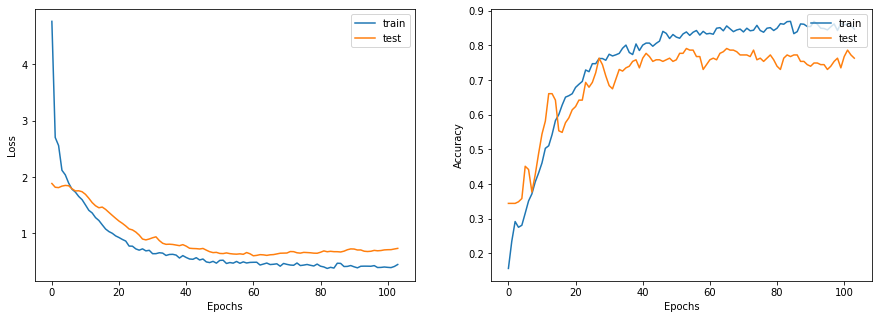

In [22]:
display_learning_curves(history)

In [23]:
_, test_accuracy = baseline_model.evaluate(x=x_test,y=y_test,verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 76.25%


In [24]:
 # Graph Neural Net Version:

 # NumPy array representing sparse adjacency matrix:
edges = citations[["source", "target"]].to_numpy().T

 # NumPy array that includes the edge weights, that quantify the relationships
 # between nodes.
edge_weights = tf.ones(shape=edges.shape[1])

 # NumPy array that includes the node features.
   # Nodes == papers
   # Node_features == word-presence binary vectors of each paper.
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)

graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [25]:
# Constructs a Graph Convolutional Layer:
  # STEPS:
  # Prepare: 
            # Input nodes are processed using a Feed Forward Network to produce
            # a message. Process is simplified by only appplying linear transformation
            # to the representations.

  # Aggregate:
            #  Messages are aggregated with respect to the edge_weights, using 
            #  pooling operations, such as sum, mean, and max to prepares a 
            #  single aggregated message for each node.
  
  # Update:
            # node_representations and Aggregated_messages are combines and 
            # processed to produce the new state of the node.
            # IF combination_type == gru, node_representations & aggregated_messages
            # are stacked to create a sequence, then processed by a GRU layer.
            # ELSE node_repesentations and aggregated_messages are added or
            # concatenated, then processed using a Feed Foward Network.


class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [39]:
class GraphClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GraphClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.squeeze(tf.gather(x, input_node_indices))
        # Compute logits
        return self.compute_logits(node_embeddings)  


In [47]:
graph_model = GraphClassifier(
    graph_info = graph_info,
    num_classes = num_classes,
    hidden_units = hidden_units,
    dropout_rate = dropout_rate,
    name="model",
)

x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)



Epoch 1/300
5/5 [==============================] - 6s 288ms/step - loss: 2.2239 - acc: 0.1863 - val_loss: 1.9011 - val_acc: 0.3442
Epoch 2/300
5/5 [==============================] - 1s 177ms/step - loss: 2.0231 - acc: 0.2655 - val_loss: 1.8753 - val_acc: 0.3442
Epoch 3/300
5/5 [==============================] - 1s 199ms/step - loss: 1.8997 - acc: 0.2836 - val_loss: 1.8726 - val_acc: 0.3442
Epoch 4/300
5/5 [==============================] - 1s 171ms/step - loss: 1.8758 - acc: 0.2910 - val_loss: 1.8679 - val_acc: 0.3442
Epoch 5/300
5/5 [==============================] - 1s 163ms/step - loss: 1.8463 - acc: 0.2968 - val_loss: 1.8527 - val_acc: 0.3442
Epoch 6/300
5/5 [==============================] - 1s 166ms/step - loss: 1.8359 - acc: 0.2951 - val_loss: 1.8345 - val_acc: 0.3442
Epoch 7/300
5/5 [==============================] - 1s 164ms/step - loss: 1.8338 - acc: 0.3017 - val_loss: 1.8129 - val_acc: 0.3442
Epoch 8/300
5/5 [==============================] - 1s 165ms/step - loss: 1.8214 - a

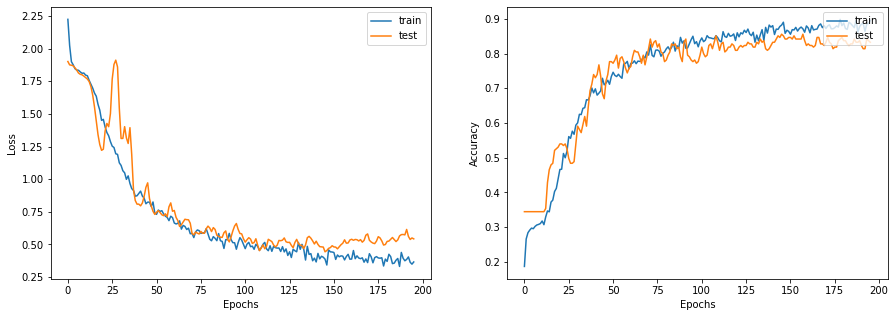

In [48]:
display_learning_curves(history)


In [49]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")


Test accuracy: 82.19%
